In [1]:
import numpy as np
import networkx as nx
from scipy.stats import norm
import cv2
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
uploaded = files.upload()

Saving 8863_idx5_x151_y1301_class0.png to 8863_idx5_x151_y1301_class0.png


In [3]:
image = cv2.imread('8863_idx5_x151_y1301_class0.png')

In [4]:
import cv2

def read_img(image):
    image = cv2.resize(image, (30, 30))              # Resize to 30x30 pixels
    return image

In [5]:
img = read_img(image)
img

array([[[157, 120, 207],
        [150, 111, 209],
        [151, 111, 189],
        ...,
        [161, 125, 210],
        [154, 118, 215],
        [164, 127, 217]],

       [[151, 111, 198],
        [162, 132, 209],
        [159, 120, 208],
        ...,
        [169, 136, 219],
        [167, 133, 220],
        [161, 126, 214]],

       [[147, 108, 178],
        [148, 101, 184],
        [137,  93, 169],
        ...,
        [165, 133, 218],
        [166, 133, 221],
        [180, 148, 213]],

       ...,

       [[162, 125, 211],
        [174, 138, 207],
        [135,  88, 143],
        ...,
        [156, 112, 176],
        [145, 100, 168],
        [158, 118, 197]],

       [[176, 140, 211],
        [163, 129, 204],
        [149,  99, 163],
        ...,
        [157, 115, 195],
        [134,  82, 152],
        [162, 125, 199]],

       [[155, 118, 207],
        [164, 125, 197],
        [151, 114, 203],
        ...,
        [170, 131, 195],
        [147, 102, 165],
        [158, 118, 179]]], dtype=uint8)

In [6]:
import numpy as np
import networkx as nx
from scipy.stats import norm

# function to get a grapgh from img, c, s, theta
#img: a 2-dim matrix
#c: the filter criterion, if the state is lower than c then the cell is filtered
#s: diminishing parameter (the sigma of Gaussian distribution)  s is used for distance closeness
#Theta: threadhold of the network edge weight
#L: the lambda (the similarity and closeness weight)

def RecurNet(img, c, s, Theta, L):

    if img.ndim != 3 or img.shape[2] != 3:
        raise ValueError("Input image must be an RGB image with three channels.")

    # Size of the image
    m, n, _ = img.shape

    # Generate the node list
    Mx = np.arange(1, m + 1)
    My = np.arange(1, n + 1)
    X, Y = np.meshgrid(Mx, My)
    X = X.flatten()
    Y = Y.flatten()

    # Initialize an empty list for nodes
    V = []

    # Process each channel (R, G, B)
    for channel in range(3):
        channel_data = img[:, :, channel].flatten()
        V_channel = np.column_stack((X, Y, channel_data))
        V.append(V_channel[V_channel[:, 2] >= c])

    # Combine nodes from all channels
    V = np.vstack(V)
    l = V.shape[0]

    # State range
    R = np.max(V[:, 2]) - np.min(V[:, 2])

    # Edge list
    F, T = np.meshgrid(np.arange(1, l + 1), np.arange(1, l + 1))
    F = F.flatten()
    T = T.flatten()
    E = np.column_stack((F, T))  # X:start, Y:end
    E = E[E[:, 0] < E[:, 1], :]  # only one direction

    # State difference in percentage
    S_diff = np.abs(V[E[:, 0] - 1, 2] - V[E[:, 1] - 1, 2]) / R
    Ipq = 1 - S_diff

    # Distance
    S_dist = np.sqrt((V[E[:, 0] - 1, 0] - V[E[:, 1] - 1, 0]) ** 2 +
                     (V[E[:, 0] - 1, 1] - V[E[:, 1] - 1, 1]) ** 2)

    # Gaussian diminishing effect
    factor_norm = norm.pdf(0, 0, s)
    Dpq = norm.pdf(S_dist, 0, s) / factor_norm
    Wpq = (Ipq**((1-L)/L)) * (Dpq**(L/(1-L)))

    # Create edge list with weights
    E = np.column_stack((E, Wpq))
    E = E[E[:, 2] > Theta, :]  # Filter edges based on threshold

    # Generate Recurrence Network
    G = nx.Graph()
    G.add_weighted_edges_from(E[:, :3])  # Add edges with weights

    return G

In [7]:
import numpy as np
import networkx as nx

def NetStatL(G):
    # Check if the graph is connected

    K = np.array(list(dict(G.degree()).values()))  # degree
    PL = dict(nx.all_pairs_shortest_path_length(G))
    max_length = max(len(lengths) for lengths in PL.values())
    PL_array = np.array([list(lengths.values()) + [np.nan] * (max_length - len(lengths)) for lengths in PL.values()])

    m, n = PL_array.shape
    for i in range(n - 1):
        PL_array[i + 1:m, i] = 0
    PL_array = PL_array.flatten()
    PL_array = PL_array[PL_array > 0]
    PL_array = PL_array[PL_array != np.inf]

    le = np.mean(PL_array)
    PC = nx.pagerank(G)
    BC = nx.betweenness_centrality(G)  # betweenness centrality
    CC = nx.closeness_centrality(G)  # closeness centrality
    betw = nx.betweenness_centrality(G)  # node betweenness
    AvgND = np.mean([np.mean([G.degree(neighbor) for neighbor in G.neighbors(node)]) for node in G.nodes()])  # average degree of neighboring nodes for every vertex

    return K, le, PC, BC, CC, betw, AvgND

In [8]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

def NetFeature(k, PLli, betC):
    # Degree K
    stat_K_Q0 = np.min(k)
    stat_K_Q1 = np.quantile(k, 0.25)
    stat_K_Q2 = np.quantile(k, 0.50)
    stat_K_Q3 = np.quantile(k, 0.75)
    stat_K_Q4 = np.max(k)
    stat_K_mean = np.mean(k)
    stat_K_sd = np.std(k)
    stat_K_skew = skew(k)
    stat_K_kurtosis = kurtosis(k)

    # Shortest Path: L
    stat_L_Q0 = np.min(PLli)
    stat_L_Q1 = np.quantile(PLli, 0.25)
    stat_L_Q2 = np.quantile(PLli, 0.50)
    stat_L_Q3 = np.quantile(PLli, 0.75)
    stat_L_Q4 = np.max(PLli)
    stat_L_mean = np.mean(PLli)
    stat_L_sd = np.std(PLli)
    stat_L_skew = skew(PLli)
    stat_L_kurtosis = kurtosis(PLli)

    # Betweenness Centrality: BC
    stat_BC_Q0 = np.min(betC)
    stat_BC_Q1 = np.quantile(betC, 0.25)
    stat_BC_Q2 = np.quantile(betC, 0.50)
    stat_BC_Q3 = np.quantile(betC, 0.75)
    stat_BC_Q4 = np.max(betC)
    stat_BC_mean = np.mean(betC)
    stat_BC_sd = np.std(betC)
    stat_BC_skew = skew(betC)
    stat_BC_kurtosis = kurtosis(betC)

    T = [
        stat_K_Q0, stat_K_Q1, stat_K_Q2, stat_K_Q3, stat_K_Q4,
        stat_K_mean, stat_K_sd, stat_K_skew, stat_K_kurtosis,
        stat_L_Q0, stat_L_Q1, stat_L_Q2, stat_L_Q3, stat_L_Q4,
        stat_L_mean, stat_L_sd, stat_L_skew, stat_L_kurtosis,
        stat_BC_Q0, stat_BC_Q1, stat_BC_Q2, stat_BC_Q3, stat_BC_Q4,
        stat_BC_mean, stat_BC_sd, stat_BC_skew, stat_BC_kurtosis
    ]

    Tn = pd.DataFrame([T], columns=[
        'stat_K_Q0', 'stat_K_Q1', 'stat_K_Q2', 'stat_K_Q3', 'stat_K_Q4',
        'stat_K_mean', 'stat_K_sd', 'stat_K_skew', 'stat_K_kurtosis',
        'stat_L_Q0', 'stat_L_Q1', 'stat_L_Q2', 'stat_L_Q3', 'stat_L_Q4',
        'stat_L_mean', 'stat_L_sd', 'stat_L_skew', 'stat_L_kurtosis',
        'stat_BC_Q0', 'stat_BC_Q1', 'stat_BC_Q2', 'stat_BC_Q3', 'stat_BC_Q4',
        'stat_BC_mean', 'stat_BC_sd', 'stat_BC_skew', 'stat_BC_kurtosis'
    ])

    return Tn, T


In [9]:
pixels = img.reshape(-1, 3)
pixels.shape

(900, 3)

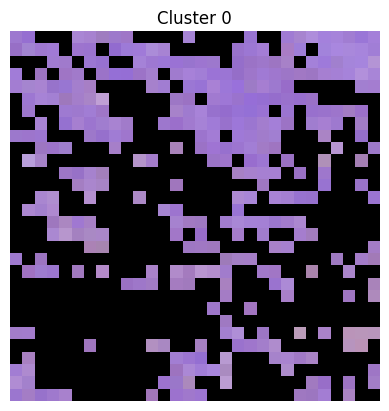

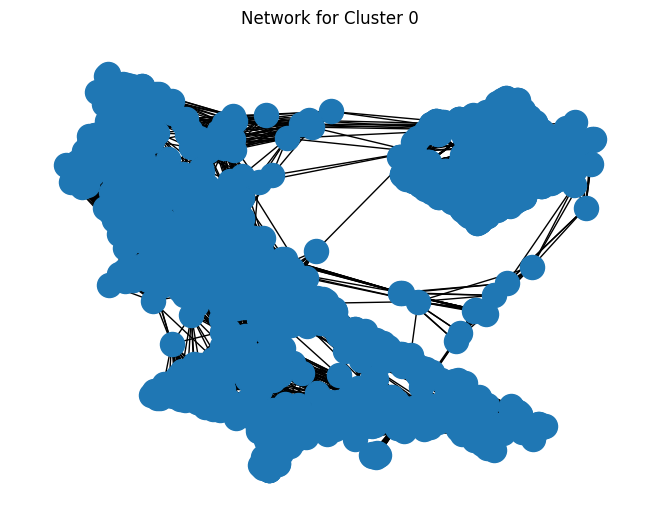

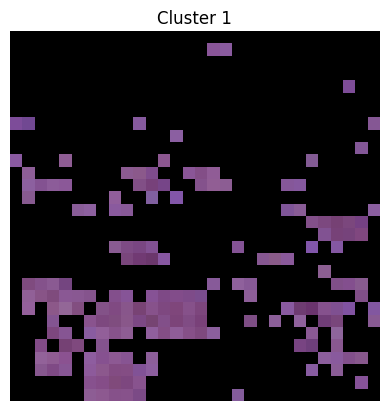

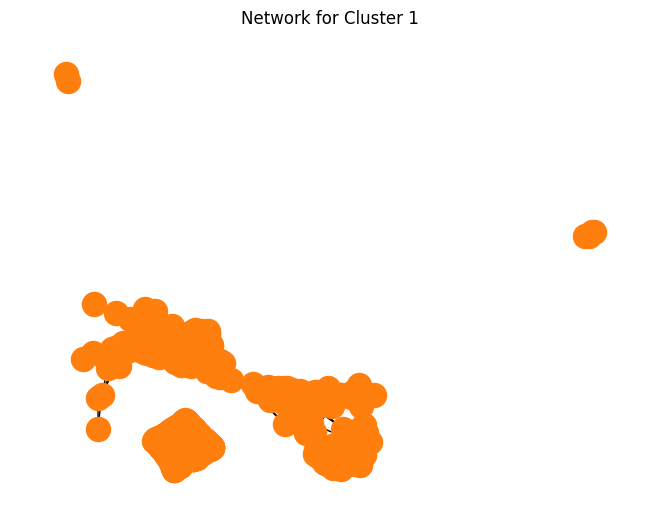

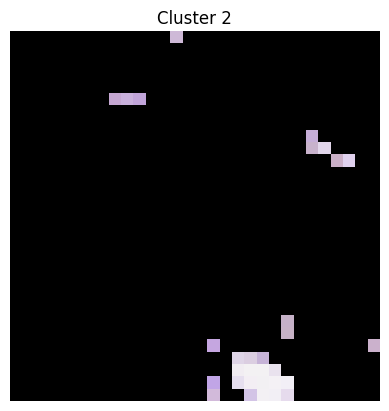

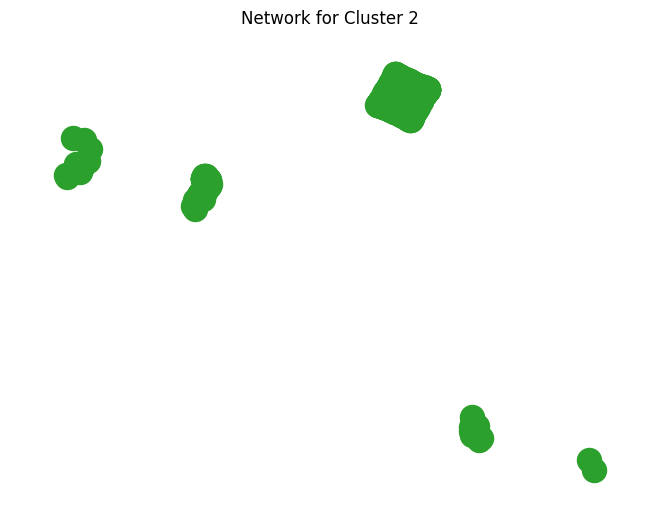

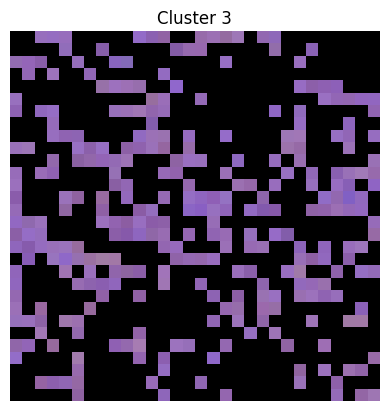

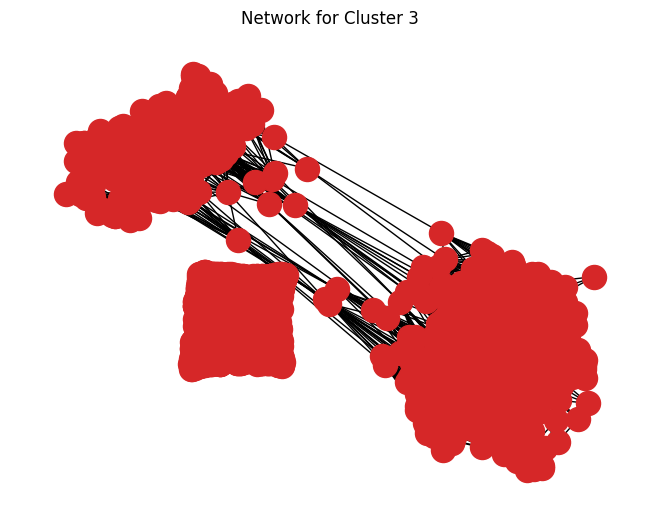

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

np.random.seed(5)
# Apply KMeans clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(pixels)
labels = kmeans.labels_

# Step 4: Create a mask for each cluster and visualize
for cluster in range(4):
    mask = (labels == cluster)
    cluster_pixels = pixels[mask]

    # Create an image for the cluster
    cluster_image = np.zeros_like(pixels)
    cluster_image[mask] = cluster_pixels
    cluster_image = cluster_image.reshape(img.shape)

    # Display the cluster image
    plt.imshow(cluster_image)
    plt.title(f'Cluster {cluster}')
    plt.axis('off')
    plt.show()


# Generate the network for the current cluster
    G = RecurNet(cluster_image, 0, 10, 0.85, 0.4)

    # Draw the network for the current cluster
    plt.figure()
    nx.draw(G, with_labels=False, font_weight='bold', node_color=f'C{cluster}')  # Different color for each cluster
    plt.title(f'Network for Cluster {cluster}')
    plt.show()

In [12]:
labels

array([0, 0, 3, 3, 3, 0, 0, 0, 0, 0, 3, 3, 3, 2, 0, 3, 3, 3, 3, 0, 3, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 3,
       3, 3, 1, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 3, 3, 3, 0, 0, 3,
       0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,
       0, 0, 0, 3, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 0,
       0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 1, 0, 0, 3, 0, 0, 0,
       0, 0, 0, 0, 2, 2, 2, 3, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       3, 3, 3, 3, 3, 0, 3, 3, 0, 0, 0, 0, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 3, 1, 1, 0, 3, 0, 0, 0, 0, 0, 0,
       1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 1, 0, 0,
       0, 3, 3, 3, 0, 0, 0, 0, 3, 3, 3, 1, 3, 0, 0, 3, 0, 0, 0, 0, 3, 3,
       2, 0, 3, 3, 0, 3, 3, 3, 0, 0, 0, 3, 3, 3, 0, 3, 3, 3, 3, 0, 3, 0,
       0, 0, 0, 0, 0, 0, 3, 3, 2, 2, 0, 3, 1, 0, 1,

In [13]:
cluster_pixels1 = pixels[labels == 0]

In [14]:
cluster_pixels1.shape

(372, 3)

In [15]:
cluster_pixels2 =pixels[labels == 1]

In [16]:
cluster_pixels2.shape

(185, 3)

In [17]:
cluster_pixels3 =pixels[labels == 2]

In [18]:
cluster_pixels3.shape

(31, 3)

In [19]:
cluster_pixels4 = pixels[labels == 3]

In [20]:
cluster_pixels4.shape

(312, 3)

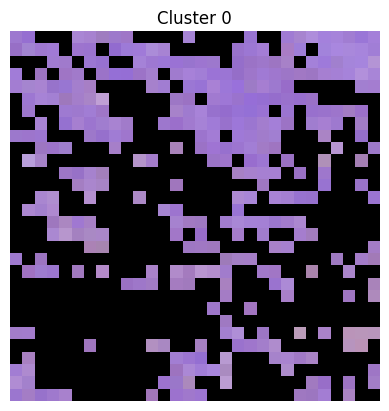

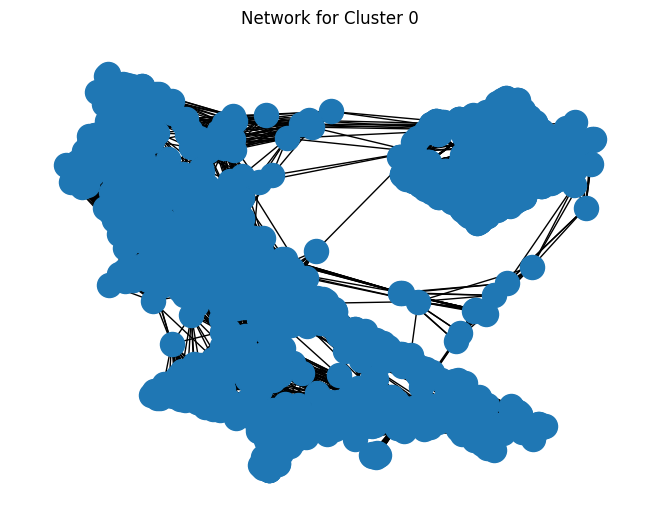

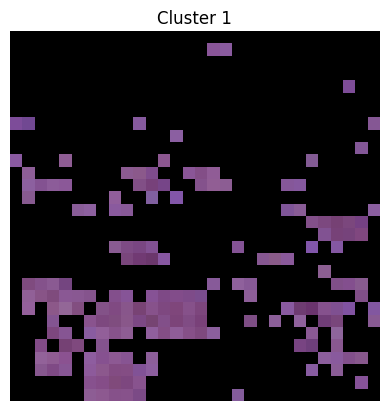

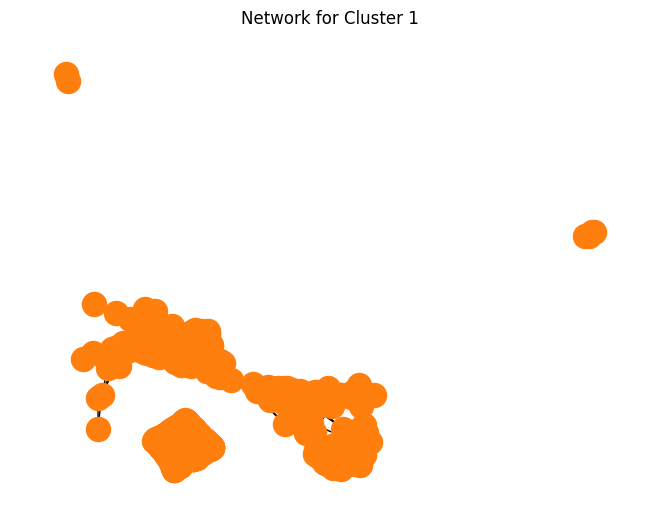

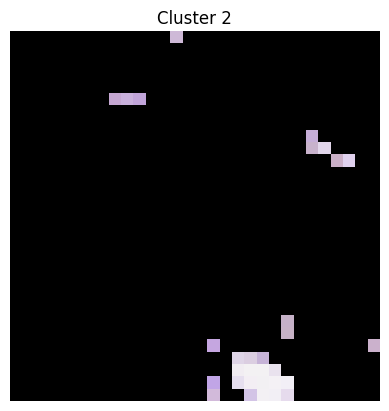

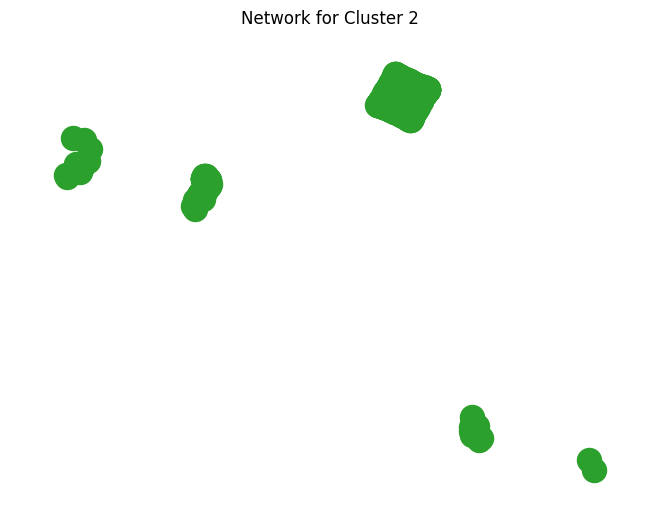

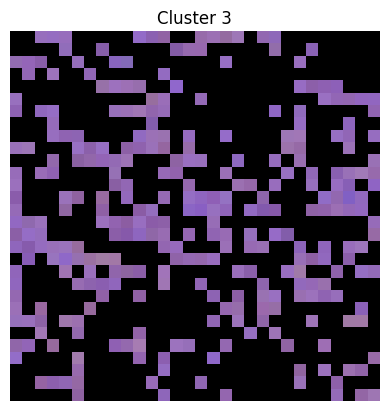

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

np.random.seed(5)


# Apply KMeans clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(pixels)
labels = kmeans.labels_

# Initialize variables to hold cluster images
cluster_image_0 = None
cluster_image_1 = None
cluster_image_2 = None
cluster_image_3 = None

# Step 4: Create a mask for each cluster and visualize
for cluster in range(4):
    mask = (labels == cluster)
    cluster_pixels = pixels[mask]

    # Create an image for the cluster
    cluster_image = np.zeros_like(pixels)
    cluster_image[mask] = cluster_pixels
    cluster_image = cluster_image.reshape(img.shape)

    # Save the cluster image to the corresponding variable
    if cluster == 0:
        cluster_image_0 = cluster_image
    elif cluster == 1:
        cluster_image_1 = cluster_image
    elif cluster == 2:
        cluster_image_2 = cluster_image
    elif cluster == 3:
        cluster_image_3 = cluster_image

    # Display the cluster image
    plt.imshow(cluster_image)
    plt.title(f'Cluster {cluster}')
    plt.axis('off')
    plt.show()

    # Generate the network for the current cluster
    G = RecurNet(cluster_image, 0, 10, 0.85, 0.4)

    # Draw the network for the current cluster
    plt.figure()
    nx.draw(G, with_labels=False, font_weight='bold', node_color=f'C{cluster}')  # Different color for each cluster
    plt.title(f'Network for Cluster {cluster}')
    plt.show()



In [22]:
cluster_image_0

array([[[157, 120, 207],
        [150, 111, 209],
        [  0,   0,   0],
        ...,
        [161, 125, 210],
        [154, 118, 215],
        [164, 127, 217]],

       [[151, 111, 198],
        [162, 132, 209],
        [159, 120, 208],
        ...,
        [169, 136, 219],
        [167, 133, 220],
        [161, 126, 214]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [165, 133, 218],
        [166, 133, 221],
        [180, 148, 213]],

       ...,

       [[162, 125, 211],
        [174, 138, 207],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [158, 118, 197]],

       [[176, 140, 211],
        [163, 129, 204],
        [  0,   0,   0],
        ...,
        [157, 115, 195],
        [  0,   0,   0],
        [162, 125, 199]],

       [[155, 118, 207],
        [164, 125, 197],
        [151, 114, 203],
        ...,
        [170, 131, 195],
        [  0,   0,   0],
        [  0,   0,   0]]], dtype=uint8)

In [ ]:
cluster_image_1

In [24]:
cluster_image_2

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [25]:
cluster_image_3

array([[[  0,   0,   0],
        [  0,   0,   0],
        [151, 111, 189],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[147, 108, 178],
        [148, 101, 184],
        [137,  93, 169],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [156, 112, 176],
        [145, 100, 168],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [149,  99, 163],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [147, 102, 165],
        [158, 118, 179]]], dtype=uint8)

In [26]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

def NetFeature(k, PLli, betC):
    # Degree K
    stat_K_Q0 = np.min(k)
    stat_K_Q1 = np.quantile(k, 0.25)
    stat_K_Q2 = np.quantile(k, 0.50)
    stat_K_Q3 = np.quantile(k, 0.75)
    stat_K_Q4 = np.max(k)
    stat_K_mean = np.mean(k)
    stat_K_sd = np.std(k)
    stat_K_skew = skew(k)
    stat_K_kurtosis = kurtosis(k)

    # Shortest Path: L
    stat_L_Q0 = np.min(PLli)
    stat_L_Q1 = np.quantile(PLli, 0.25)
    stat_L_Q2 = np.quantile(PLli, 0.50)
    stat_L_Q3 = np.quantile(PLli, 0.75)
    stat_L_Q4 = np.max(PLli)
    stat_L_mean = np.mean(PLli)
    stat_L_sd = np.std(PLli)
    stat_L_skew = skew(PLli)
    stat_L_kurtosis = kurtosis(PLli)

    # Betweenness Centrality: BC
    stat_BC_Q0 = np.min(betC)
    stat_BC_Q1 = np.quantile(betC, 0.25)
    stat_BC_Q2 = np.quantile(betC, 0.50)
    stat_BC_Q3 = np.quantile(betC, 0.75)
    stat_BC_Q4 = np.max(betC)
    stat_BC_mean = np.mean(betC)
    stat_BC_sd = np.std(betC)
    stat_BC_skew = skew(betC)
    stat_BC_kurtosis = kurtosis(betC)

    T = [
        stat_K_Q0, stat_K_Q1, stat_K_Q2, stat_K_Q3, stat_K_Q4,
        stat_K_mean, stat_K_sd, stat_K_skew, stat_K_kurtosis,
        stat_L_Q0, stat_L_Q1, stat_L_Q2, stat_L_Q3, stat_L_Q4,
        stat_L_mean, stat_L_sd, stat_L_skew, stat_L_kurtosis,
        stat_BC_Q0, stat_BC_Q1, stat_BC_Q2, stat_BC_Q3, stat_BC_Q4,
        stat_BC_mean, stat_BC_sd, stat_BC_skew, stat_BC_kurtosis
    ]

    Tn = pd.DataFrame([T], columns=[
        'stat_K_Q0', 'stat_K_Q1', 'stat_K_Q2', 'stat_K_Q3', 'stat_K_Q4',
        'stat_K_mean', 'stat_K_sd', 'stat_K_skew', 'stat_K_kurtosis',
        'stat_L_Q0', 'stat_L_Q1', 'stat_L_Q2', 'stat_L_Q3', 'stat_L_Q4',
        'stat_L_mean', 'stat_L_sd', 'stat_L_skew', 'stat_L_kurtosis',
        'stat_BC_Q0', 'stat_BC_Q1', 'stat_BC_Q2', 'stat_BC_Q3', 'stat_BC_Q4',
        'stat_BC_mean', 'stat_BC_sd', 'stat_BC_skew', 'stat_BC_kurtosis'
    ])

    return Tn, T


In [27]:
CI = [cluster_image_0,cluster_image_1, cluster_image_2,cluster_image_3]
CI

[array([[[157, 120, 207],
         [150, 111, 209],
         [  0,   0,   0],
         ...,
         [161, 125, 210],
         [154, 118, 215],
         [164, 127, 217]],
 
        [[151, 111, 198],
         [162, 132, 209],
         [159, 120, 208],
         ...,
         [169, 136, 219],
         [167, 133, 220],
         [161, 126, 214]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [165, 133, 218],
         [166, 133, 221],
         [180, 148, 213]],
 
        ...,
 
        [[162, 125, 211],
         [174, 138, 207],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [158, 118, 197]],
 
        [[176, 140, 211],
         [163, 129, 204],
         [  0,   0,   0],
         ...,
         [157, 115, 195],
         [  0,   0,   0],
         [162, 125, 199]],
 
        [[155, 118, 207],
         [164, 125, 197],
         [151, 114, 203],
         ...,
         [170, 131, 195],
  

In [29]:
G = []


for i in range(len(CI)):
    G.append(RecurNet(CI[i], 0, 10, 0.85,0.4))  # Assuming RecurNet returns a graph

In [30]:
G

In [31]:
k=[]
for i in range(len(CI)):
    k.append( np.array(list(dict(G[i].degree()).values())))  # Assuming RecurNet returns a graph

In [32]:
k

[array([23, 21, 53, ..., 21, 92, 77]),
 array([128, 149, 170, ..., 125, 104,  92]),
 array([128, 149, 170, ..., 152, 140, 125]),
 array([ 83, 101,  14, ..., 125,  18,   9])]

In [33]:
def cpl(G):
  PL = nx.all_pairs_shortest_path_length(G)
  PL = dict(nx.all_pairs_shortest_path_length(G))
  max_length = max(len(lengths) for lengths in PL.values())
  PL_array = np.array([list(lengths.values()) + [np.nan] * (max_length - len(lengths)) for lengths in PL.values()])

  m, n = PL_array.shape
  for i in range(n - 1):
      PL_array[i + 1:m, i] = 0
  PL_array = PL_array.flatten()
  PL_array = PL_array[PL_array > 0]
  PL_array = PL_array[PL_array != np.inf]
  le = np.mean(PL_array)
  return le

In [34]:
PLli=[]
for i in range(len(CI)):
  PLli.append(cpl(G[i]))

In [35]:
PLli

[3.924749465812517, 3.516743023085149, 3.5034865068267025, 3.765566319316273]

In [ ]:
betC=[]
for i in range(len(CI)):
  betC.append(nx.betweenness_centrality(G[i]))

In [42]:
betC = [list(d.values()) for d in betC]
betC

[[2.840494378185289e-06,
  5.9464127346194074e-05,
  1.2350720178551696e-06,
  3.94568209353414e-06,
  8.326733483546052e-06,
  8.879637771395631e-06,
  2.91916941761034e-05,
  8.119986618553818e-05,
  9.638262283806368e-05,
  9.445617063683439e-05,
  4.0350362019844825e-05,
  6.441617592805408e-05,
  6.426321940985513e-05,
  2.896168642822721e-05,
  3.2226486640702324e-05,
  8.722515979545972e-05,
  3.0466498452355904e-05,
  3.771278828666666e-05,
  0.00015975759687915635,
  0.00010651165208007975,
  9.872503837773685e-05,
  0.0004696083620608308,
  0.00021596745205450967,
  2.461056205309794e-05,
  3.555551531323274e-05,
  8.586444084101525e-05,
  4.3103616849720646e-05,
  0.00013615433318867892,
  0.00028579024881561027,
  2.9965393132485572e-05,
  8.705565758283606e-05,
  6.805097585031987e-06,
  9.814478664343294e-06,
  1.8965520571216937e-05,
  1.9637670850961782e-05,
  0.0001121527857677674,
  0.0002807244049293788,
  7.601782353363537e-05,
  0.0007650156135529123,
  0.000194345

In [43]:
features = []
for i in range(len(CI)):
    features.append(NetFeature(k[i], PLli[i], betC[i]))

In [44]:
features

[(   stat_K_Q0  stat_K_Q1  stat_K_Q2  stat_K_Q3  stat_K_Q4  stat_K_mean  \
  0          5       44.0      152.0      260.0        380   152.951111   
  
      stat_K_sd  stat_K_skew  stat_K_kurtosis  stat_L_Q0  ...  stat_L_kurtosis  \
  0  110.125076     0.226154        -1.455965   3.924749  ...              NaN   
  
     stat_BC_Q0  stat_BC_Q1  stat_BC_Q2  stat_BC_Q3  stat_BC_Q4  stat_BC_mean  \
  0         0.0    0.000092    0.000295    0.000653    0.007837      0.000463   
  
     stat_BC_sd  stat_BC_skew  stat_BC_kurtosis  
  0     0.00061      4.805905         39.210549  
  
  [1 rows x 27 columns],
  [5,
   44.0,
   152.0,
   260.0,
   380,
   152.95111111111112,
   110.12507627553026,
   0.22615422184387576,
   -1.455965017996038,
   3.924749465812517,
   3.924749465812517,
   3.924749465812517,
   3.924749465812517,
   3.924749465812517,
   3.924749465812517,
   0.0,
   nan,
   nan,
   0.0,
   9.197028765359345e-05,
   0.00029458462585953116,
   0.0006525386287981696,
   0.007

In [45]:
dfnew = pd.DataFrame()

dfnew

""


In [46]:
for i in range(len(CI)):
    dfnew = pd.concat([dfnew, features[i][0]], ignore_index=True)

In [47]:
dfnew

,stat_K_Q0,stat_K_Q1,stat_K_Q2,stat_K_Q3,stat_K_Q4,stat_K_mean,stat_K_sd,stat_K_skew,stat_K_kurtosis,stat_L_Q0,...,stat_L_kurtosis,stat_BC_Q0,stat_BC_Q1,stat_BC_Q2,stat_BC_Q3,stat_BC_Q4,stat_BC_mean,stat_BC_sd,stat_BC_skew,stat_BC_kurtosis
0,5,44.0,152.0,260.0,380,152.951111,110.125076,0.226154,-1.455965,3.924749,...,NaN,0.0,0.000092,0.000295,0.000653,0.007837,0.000463,0.000610,4.805905,39.210549
1,1,143.0,264.5,344.0,419,234.865185,126.541849,-0.501699,-1.041810,3.516743,...,NaN,0.0,0.000096,0.000326,0.000844,0.009821,0.000504,0.000517,3.155911,40.482082
2,1,266.0,356.0,425.0,434,334.376436,101.319095,-1.106784,0.959062,3.503487,...,NaN,0.0,0.000144,0.000533,0.001145,0.001793,0.000654,0.000541,0.408534,-1.201032
3,3,37.0,188.0,254.0,332,161.972593,105.657329,-0.203000,-1.539715,3.765566,...,NaN,0.0,0.000101,0.000318,0.000703,0.010308,0.000470,0.000561,5.631688,69.495095
